# Problem Description: Burger's Equation

Governing equation $$u_t + uu_x = vu_{xx}, \quad x\in [-1,1],\quad t>0$$
where $ \nu=0.01/\pi$

Initial Condition: $$u(x,0) = a_i$$
Boundary Condition: $$u(-1,t)=u(1,t)=0$$


In [18]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset

In [19]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
def convert_np_to_tensor(array):
  if isinstance(array, np.ndarray):
    # Convert NumPy array to PyTorch tensor
    tensor = torch.from_numpy(array)
    return tensor.to(torch.float32)
  else:
    return array

In [23]:
d =  np.load("C:/Users/admin/Desktop/김도형/코드/Dataset/train_burgers_3.npz",allow_pickle=True)
branch_np, trunk_np, Y_np = d["branch"], d["trunk"], d["y"]
branch   = convert_np_to_tensor(branch_np)
trunk   = convert_np_to_tensor(trunk_np)
Y = convert_np_to_tensor(Y_np)

print(f'branch shape: {branch.shape}, type: {type(branch)}, dtype: {branch.dtype}')
print(f'trunk shape: {trunk.shape}, type: {type(trunk)}, dtype: {trunk.dtype}')
print(f'Y shape: {Y.shape}, type: {type(Y)}, dtype: {Y.dtype}')

branch shape: torch.Size([150, 30]), type: <class 'torch.Tensor'>, dtype: torch.float32
trunk shape: torch.Size([10000, 2]), type: <class 'torch.Tensor'>, dtype: torch.float32
Y shape: torch.Size([150, 10000]), type: <class 'torch.Tensor'>, dtype: torch.float32


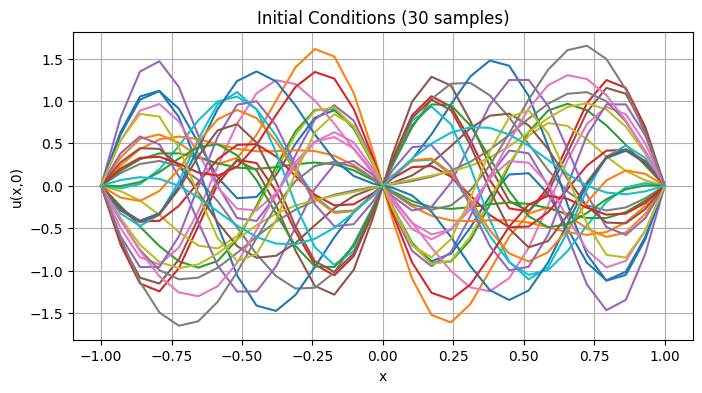

In [43]:
xs = d["xs"]
plt.figure(figsize=(8, 4))
for i in range(30):
    plt.plot(xs, branch_np[i])
plt.xlabel("x")
plt.ylabel('u(x,0)')
plt.title("Initial Conditions (30 samples)")
plt.grid(True)
plt.savefig(f"C:/Users/admin/Desktop/김도형/코드/figure_20260117_labmeeting/DeepONet_Burgers_branch_input.png", dpi=300, bbox_inches="tight")
plt.show()

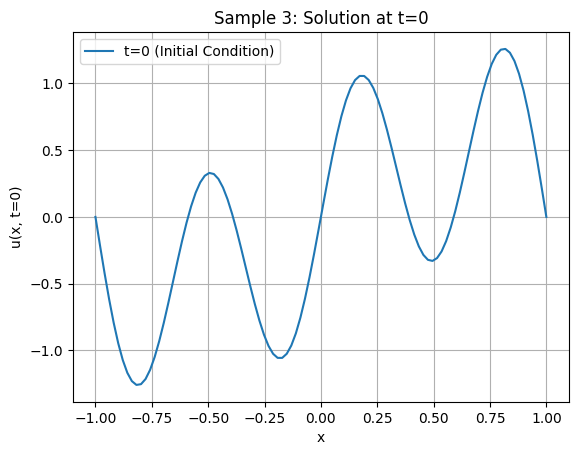

In [44]:
i = 3  # 보고 싶은 샘플 번호
Nx = 100
Nt = 100

# t=0인 지점의 인덱스 추출 (j=0 인 모든 i)
# 방법 1: 슬라이싱 활용 (0부터 시작해서 Nt 간격으로)
t0_indices = np.arange(0, Nx * Nt, Nt)
x0_indices = np.arange(0, Nt)

plt.figure()
plt.plot(trunk_np[t0_indices, 0], Y_np[i, t0_indices], c='tab:blue', label='t=0 (Initial Condition)')
plt.xlabel('x')
plt.ylabel('u(x, t=0)')
plt.title(f'Sample {i}: Solution at t=0')
plt.grid(True)
plt.legend()
plt.show()

In [45]:
class Datahandler(Dataset):
  def __init__(self, u_branch, y_trunk, guy):
    self.u_branch = u_branch
    self.y_trunk = y_trunk
    self.guy = guy

  def __len__(self):
    return len(self.guy)

  def __getitem__(self, index):
    return self.u_branch[index,:], self.y_trunk, self.guy[index,:]

In [46]:
dataset = Datahandler(branch, trunk, Y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 150, shuffle=True)

In [47]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.bias = nn.Parameter(torch.tensor(1.0), requires_grad=True)

        self.branch = nn.Sequential(
            nn.Linear(30, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40)
        )

        self.trunk = nn.Sequential(
            nn.Linear(2, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40,40)
        )
    
    def forward(self, branch, trunk):
        branch_out = self.branch(branch)
        trunk_out  = self.trunk(trunk)
        out = branch_out @ trunk_out.T + self.bias
        return out

def init_weights(m): 
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data) 
        nn.init.zeros_(m.bias)

In [48]:
model = Network()
model.apply(init_weights)

Network(
  (branch): Sequential(
    (0): Linear(in_features=30, out_features=40, bias=True)
    (1): Tanh()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): Tanh()
    (4): Linear(in_features=40, out_features=40, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1): Tanh()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): Tanh()
    (4): Linear(in_features=40, out_features=40, bias=True)
  )
)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
train_history = {'loss':[]}

In [50]:
n_epochs = 10000
for epoch in range(n_epochs):
  losses = []
  for branch_batch, _, Y_batch in dataloader: 
    optimizer.zero_grad()

    pred = model(branch_batch, trunk)
    loss = loss_fn(pred, Y_batch)

    loss.backward()

    losses.append(loss.item())

    optimizer.step()

  avg_loss = np.mean(losses)
  if epoch%1000 == 0:
    print(f'Epoch: {epoch}, Loss: {float(avg_loss): .2}')

Epoch: 0, Loss:  1.6
Epoch: 1000, Loss:  0.13
Epoch: 2000, Loss:  0.097
Epoch: 3000, Loss:  0.088
Epoch: 4000, Loss:  0.068
Epoch: 5000, Loss:  0.063
Epoch: 6000, Loss:  0.055
Epoch: 7000, Loss:  0.047
Epoch: 8000, Loss:  0.043
Epoch: 9000, Loss:  0.04


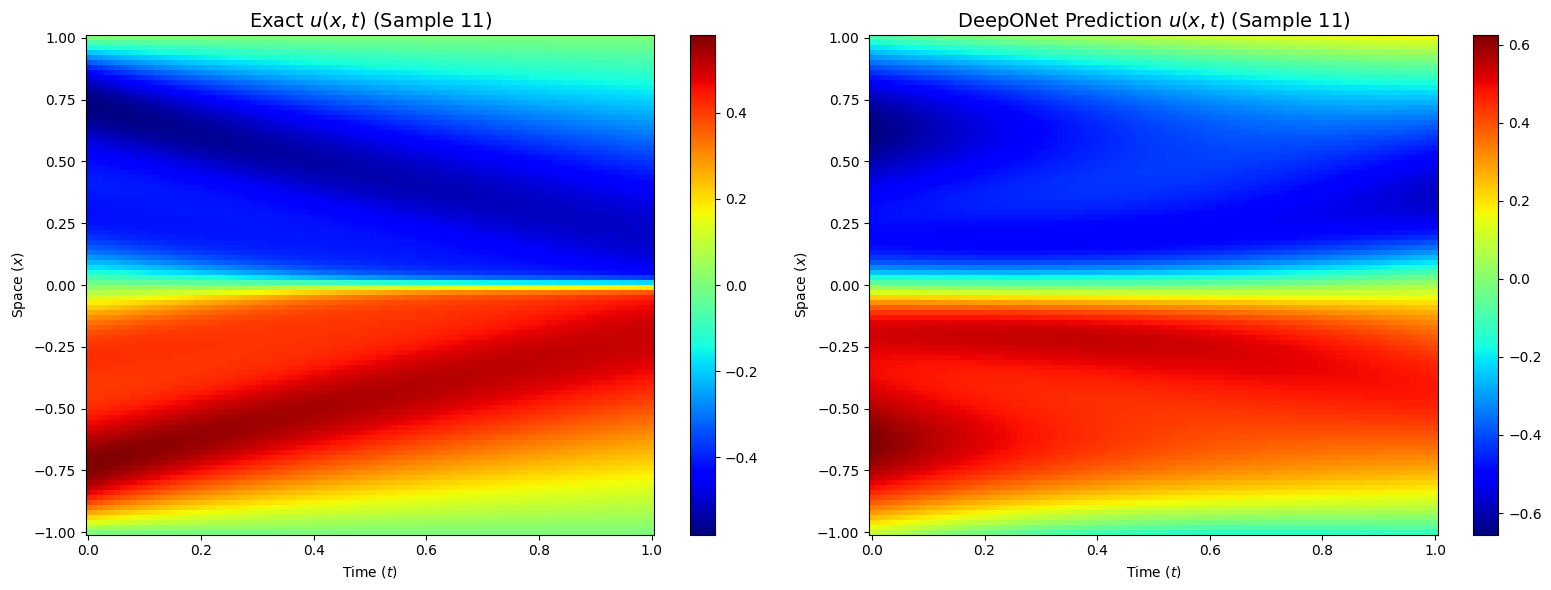

--- 검증: t=0 (첫 번째 열) 데이터 비교 ---
Ground Truth의 t=0 첫 5값: [0. 0. 0. 0. 0.]
Prediction의 t=0 첫 5값: [0.10346657 0.09581453 0.08828223 0.08086777 0.073578  ]


In [ ]:
# 1. 인덱스 및 격자 설정
i = 11 
Nx, Nt = 100, 100

model.eval()
with torch.no_grad():
    u_pred = model(branch[i].unsqueeze(0), trunk)
    u_pred_np = u_pred.cpu().numpy().flatten()

# 2. 데이터 구조 복원 (핵심 수정 부분)
# 데이터가 x가 먼저 변하는 순서이므로 (Nt, Nx)로 만든 뒤 Transpose 하거나
# 직접 (Nt, Nx) 형태로 구조를 잡아야 합니다.
U_true = Y_np[i].reshape(Nt, Nx).T  # (Nx, Nt) 형태로 변환
U_pred = u_pred_np.reshape(Nt, Nx).T

# 좌표 데이터 (동일하게 x가 먼저 변하는 순서로 복원)
X_grid = trunk_np[:, 0].reshape(Nt, Nx).T
T_grid = trunk_np[:, 1].reshape(Nt, Nx).T

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# [좌] 실제 데이터 (Ground Truth)
im0 = ax[0].pcolormesh(T_grid, X_grid, U_true, cmap='jet', shading='auto')
ax[0].set_title(f'Exact $u(x,t)$ (Sample {i})', fontsize=14)
ax[0].set_xlabel('Time ($t$)')
ax[0].set_ylabel('Space ($x$)')
plt.colorbar(im0, ax=ax[0])

# [우] 모델 예측값 (DeepONet Prediction)
im1 = ax[1].pcolormesh(T_grid, X_grid, U_pred, cmap='jet', shading='auto')
ax[1].set_title(f'DeepONet Prediction $u(x,t)$ (Sample {i})', fontsize=14)
ax[1].set_xlabel('Time ($t$)')
ax[1].set_ylabel('Space ($x$)')
plt.colorbar(im1, ax=ax[1])

plt.tight_layout()
plt.show()

# 4. 검증을 위한 출력 (t=0일 때 데이터 확인)
print("--- 검증: t=0 (첫 번째 열) 데이터 비교 ---")
print(f"Ground Truth의 t=0 첫 5값: {U_true[:5, 0]}")
print(f"Prediction의 t=0 첫 5값: {U_pred[:5, 0]}")

In [ ]:
d =  np.load("C:/Users/admin/Desktop/김도형/코드/Dataset/test_burgers_3.npz",allow_pickle=True)
branch_test2_np, trunk_test2_np, Y_test2_np = d["branch"], d["trunk"], d["y"]
branch_test2 = convert_np_to_tensor(branch_test2_np)
trunk_test2 = convert_np_to_tensor(trunk_test2_np)
Y_test2 = convert_np_to_tensor(Y_test2_np)

print(f'branch_test shape: {branch_test2.shape}, type: {type(branch_test2)}, dtype: {branch_test2.dtype}')
print(f'trunk_test shape: {trunk_test2.shape}, type: {type(trunk_test2)}, dtype: {trunk_test2.dtype}')
print(f'Y_test shape: {Y_test2.shape}, type: {type(Y_test2)}, dtype: {Y_test2.dtype}')

branch_test shape: torch.Size([150, 30]), type: <class 'torch.Tensor'>, dtype: torch.float32
trunk_test shape: torch.Size([10000, 2]), type: <class 'torch.Tensor'>, dtype: torch.float32
Y_test shape: torch.Size([150, 10000]), type: <class 'torch.Tensor'>, dtype: torch.float32


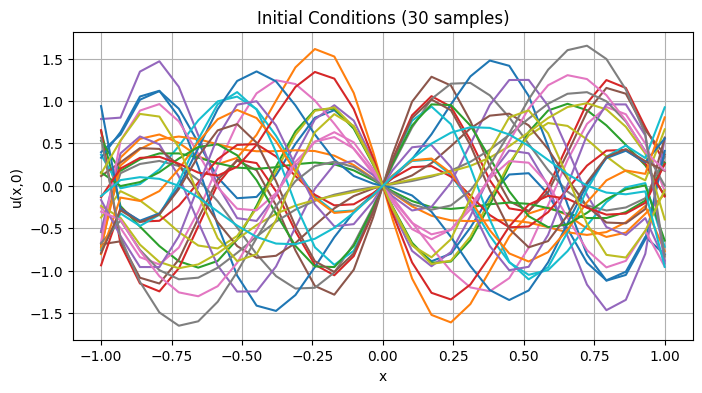

In [33]:
xs = d["xs"]
plt.figure(figsize=(8, 4))
for i in range(30):
    plt.plot(xs, branch_test2_np[i])
plt.xlabel("x")
plt.ylabel('u(x,0)')
plt.title("Initial Conditions (30 samples)")
plt.grid(True)
plt.savefig(f"C:/Users/admin/Desktop/김도형/코드/figure_20260117_labmeeting/DeepONet_Burgers_branch_input.png", dpi=300, bbox_inches="tight")
plt.show()

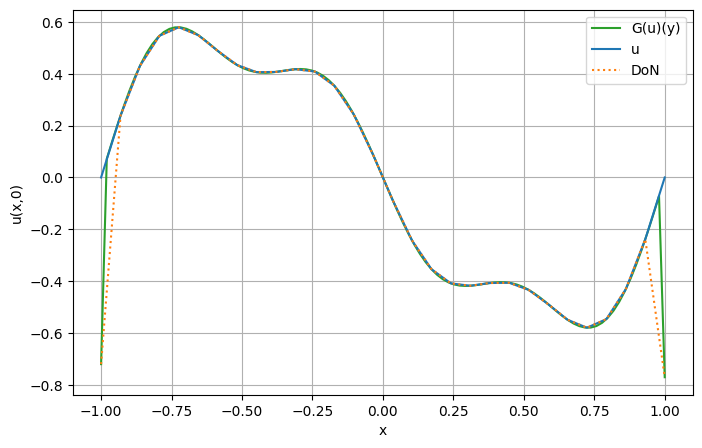

In [34]:
xgrid = d['xs']
i=11
Nx = 100
Nt = 100
t0_indices = np.arange(0, Nx * Nt, Nt)

plt.figure(figsize = (8,5))
plt.plot(trunk_np[t0_indices, 0], Y_test2_np[i, t0_indices], c='tab:green', label='G(u)(y)')
plt.plot(xgrid, branch_np[i], c='tab:blue', label='u')
plt.plot(xgrid, branch_test2_np[i], c='tab:orange', linestyle=':', label='DoN')
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.grid(True)
plt.legend()
plt.savefig(f"C:/Users/admin/Desktop/김도형/코드/figure_20260117_labmeeting/DeepONet_Burgers_idx{i}_result.png", dpi=300, bbox_inches="tight")
plt.show()